***
# **Small-MOCCA: Dataset exploration**

***
Exploration of a subset of the MOCCA Survey Dataset I. Creation of a regressión dataset for $M_{\text MMO}$ estimation.  

> Programs by J.Saavedra-Bastidas.
***

In [1]:
# General Libraries ---------------------------------------------------------------------------------------------#
import os

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
#----------------------------------------------------------------------------------------------------------------#

In [2]:
# Funtions and utilities ----------------------------------------------------------------------------------------#
from matplotlib.colors import LogNorm
from typing            import Dict, List, Tuple, Optional, Union
from dataclasses       import dataclass
#----------------------------------------------------------------------------------------------------------------#

In [3]:
# Change to working directory -----------------------------------------------------------------------------------#
os.chdir("../")
#----------------------------------------------------------------------------------------------------------------#

In [4]:
# Custome functions ---------------------------------------------------------------------------------------------#

# Exploration of files in a directory
from src.utils.directory         import list_all_directories

# Computation of physical quantities
from src.utils.phyfactors        import relaxation_time, collision_time, core_collapse_time
from src.utils.phyfactors        import critical_mass, rho_at_rh

# Data handling
from src.processing.moccasurvey  import load_moccasurvey_imbh_history
from scripts.get_features        import DataProcessor, DownsamplingProcessor

# Plot vizualization
from src.utils.vizualize         import correlation_plot, classic_correlogram, boxplot_features_with_points
from src.utils.vizualize         import plot_simulation_example, dataset_2Dhist_comparison, truncate_colormap

#----------------------------------------------------------------------------------------------------------------#

## **$\bullet$ Simulation files: Exploration**

For this project the preliminar information will always be stored at path: 
- Datapath: "./rawdata/[name_of_dataset]/simulations/*"

We will reffer to the information from the MOCCA Survey Dataset I as *moccasurvey*. 

> **Note**:   
> All simulations have a respective folder with two directory files:
>   - system.txt: Temporal evolution of the initial conditions.
>   - imbh-history.txt: Temporal evolution of the most massive object in the simulation.
>
> **Custom Function**:
>
>   - `list_all_directories()`: Retrieve the path to all folders (simulations in this case) contained in the moccasurvey directory path

In [5]:
# Load name files and directories -------------------------------------------------------------------------------#
sim_files_path = "./rawdata/moccasurvey/simulations/"
simulations    = list_all_directories(sim_files_path)

# Verbose
print(110*"_")
print(f"Total MOCCA Models available for analysis: {len(simulations)}")
print(110*"_")
#----------------------------------------------------------------------------------------------------------------#

______________________________________________________________________________________________________________
Total MOCCA Models available for analysis: 455
______________________________________________________________________________________________________________


We can make a case study for a single simulation using the function `load_moccasurvey_imbh_history()`. Each simulation file contains several elements that can be retrieved given the input:

- **imbh_df**: main dataframe with the evolution history of the most massive object in the simulation
- **imbh_init_conds**: first rows of the imbh-history file, containing some initial conditions
- **imbh_col_dict**: description of the headers in the imbh_df.
- **imbh_stellar_dict**: dictionary to map the stellar type present in the imbh_df
- **system_df**: main dataframe with the evolution of the initial conditions of the simulation
- **system_col_dict**: description of the headers in the system_df.

In [6]:
# Load simulation info ------------------------------------------------------------------------------------------#
imbh_history, system = load_moccasurvey_imbh_history(file_path = f"{simulations[27]}/",
                                                    init_conds_sim  = True,
                                                    col_description = True,
                                                    stellar_map     = True,
                                                    init_conds_evo  = True)

# Getting imbh history df, initial_conditions, column definitions, and stellar type mappig
imbh_df           = imbh_history[0]
imbh_init_conds   = imbh_history[1]
imbh_col_dict     = imbh_history[2]
imbh_stellar_dict = imbh_history[3]

# Retrive temporal evolution df of initial conditions and their column descriptions
system_df       = system[0]
system_col_dict = system[1]

#----------------------------------------------------------------------------------------------------------------#

In [7]:
# Columns of interest and details of the system df ....----------------------------------------------------------#
int_cols = ["17", "3", "23", "46", "44", "28", "2", "11"]

print(110*"_")
print("Columns of interest in the system dataframe")
for n_col in int_cols:
    print(110*"_")
    print(f"Column number      : {n_col}")
    print(f"Column name        : {system_col_dict[n_col]['column']}")
    print(f"Column description : {system_col_dict[n_col]['description']}")

print(110*"_")
print("Details of interest in the system dataframe")
print(f"Number of rows         : {len(system_df)}")
print(f"Maximun evolution time : {system_df['tphys'].max()}")
print(110*"_")
#----------------------------------------------------------------------------------------------------------------#

______________________________________________________________________________________________________________
Columns of interest in the system dataframe
______________________________________________________________________________________________________________
Column number      : 17
Column name        : r_h
Column description : actual half-mas radius in pc
______________________________________________________________________________________________________________
Column number      : 3
Column name        : smt
Column description : total mass in Msun
______________________________________________________________________________________________________________
Column number      : 23
Column name        : vc
Column description : central velocity dispersion in km/s (mass weighted)
______________________________________________________________________________________________________________
Column number      : 46
Column name        : nt
Column description : actual number of objects

In [8]:
# Columns of interest and details of the history df ....---------------------------------------------------------#
int_cols = ["4", "10"]

print(110*"_")
print("Columns of interest in the imbh history dataframe")
for n_col in int_cols:
    print(110*"_")
    print(f"Column number      : {n_col}")
    print(f"Column name        : {imbh_col_dict[n_col]['column']}")
    print(f"Column description : {imbh_col_dict[n_col]['description']}")

print(110*"_")
print("Details of interest in the imbh history dataframe")
print(f"Number of rows         : {len(imbh_df)}")
print(f"Maximun evolution time : {imbh_df['time[Myr]'].max()}")
print(110*"_")
#----------------------------------------------------------------------------------------------------------------#

______________________________________________________________________________________________________________
Columns of interest in the imbh history dataframe
______________________________________________________________________________________________________________
Column number      : 4
Column name        : time
Column description : Time of the event in Myr
______________________________________________________________________________________________________________
Column number      : 10
Column name        : massNew
Column description : Mass of the primary after the event [Msun]
______________________________________________________________________________________________________________
Details of interest in the imbh history dataframe
Number of rows         : 15350
Maximun evolution time : 14999.267
______________________________________________________________________________________________________________


In [9]:
# Extract the example of initial conditions ---------------------------------------------------------------------#
rh      = system_df["r_h"][0]
v_disp  = system_df["vc"][0]
m_tot   = system_df["smt"][0]
n       = system_df["nt"][0]
m_mean  = system_df["atot"][0]
m_max   = system_df["smsm"][0]
cr      = system_df["rc"][0]
tau     = imbh_df["time[Myr]"].max() - imbh_df["time[Myr]"].min()

print(100*"_")
print("Initial conditions for the selected simulation:")
print(100*"_")
print(f"  Half-mass radius (r_h)       : {rh:.3f} pc")
print(f"  Velocity dispersion (v_disp) : {v_disp:.3f} km/s")
print(f"  Total mass (m_tot)           : {m_tot:.3e} Msun")
print(f"  Number of stars (n)          : {n}")
print(f"  Mean stellar mass (m_mean)   : {m_mean:.3f} Msun")
print(f"  Maximum stellar mass (m_max) : {m_max:.3f} Msun")
print(f"  Core radius (rc)             : {cr:.3f} pc")
print(f"  Cluster evolution time (tau) : {tau:.3f} Myr")
print(100*"_")
#----------------------------------------------------------------------------------------------------------------#

____________________________________________________________________________________________________
Initial conditions for the selected simulation:
____________________________________________________________________________________________________
  Half-mass radius (r_h)       : 0.599 pc
  Velocity dispersion (v_disp) : 31.963 km/s
  Total mass (m_tot)           : 4.242e+05 Msun
  Number of stars (n)          : 700000
  Mean stellar mass (m_mean)   : 0.606 Msun
  Maximum stellar mass (m_max) : 99.719 Msun
  Core radius (rc)             : 0.220 pc
  Cluster evolution time (tau) : 14999.267 Myr
____________________________________________________________________________________________________


Relevant physical quatities can be computed with the functions stores in `phyfactors.py`. We leverage `astropy` to handle unit conversion.

In [10]:
# Compute an example of the relevant physical quantities --------------------------------------------------------#
t_relax  = relaxation_time(n_stars=n, hm_radius=rh, v_disp=v_disp, mtot=None)
rho_half = rho_at_rh(n_stars=n, hm_radius=rh)
t_coll   = collision_time(hm_radius=rh, n_stars=n, mass_per_star=m_mean, v_disp=v_disp, stellar_radius=1.0)
t_cc     = core_collapse_time(m_mean=m_mean, m_max=m_max, n_stars=n, hm_radius=rh, v_disp=v_disp, mtot=None)  
M_crit   = critical_mass(hm_radius=rh, mass_per_star=m_mean, cluster_age=tau, v_disp=v_disp, stellar_radius=1.0)

print(100*"_")
print("Physical timescales and quantities:")
print(100*"_")
print(f"  Relaxation time             (t_relax) : {t_relax:.3f} ")
print(f"  Collision time              (t_coll)) : {t_coll:.3f} ")
print(f"  Core collapse time          (t_cc)    : {t_cc:.3f} ")
print(f"  Density at half-mass radius (rho_rh)  : {rho_half:.3f} ")
print(f"  Critical mass               (M_crit)  : {M_crit:3e} ")
print(100*"_")
#----------------------------------------------------------------------------------------------------------------#

____________________________________________________________________________________________________
Physical timescales and quantities:
____________________________________________________________________________________________________
  Relaxation time             (t_relax) : 95.356 Myr 
  Collision time              (t_coll)) : 94932.443 Myr 
  Core collapse time          (t_cc)    : 1.912 Myr 
  Density at half-mass radius (rho_rh)  : 388159.526 1 / pc3 
  Critical mass               (M_crit)  : 6.354095e+05 solMass 
____________________________________________________________________________________________________


## **$\bullet$ Visualization**

The functions `time_preparation()` and `target_preparation()` allow for a simpler clean up of the simulation main quantities. They include parameters to normalize and leverage a safe log10 scale. Also for the target we include three types of target to prepare a regression experiment:
- `experiment_type = "point_mass"` : 

    Retrieve the actual value of mass given a time step.
- `experiment_type = "delta_mass"` : 

    Retrieve the change of mass regarding the next time step (meaning that we'll be trying to preding how much mass would the object gain in the next time step).
- `experiment_type = "mass_rate"` : 

    Retrieve the mass per time gained by the most massive object. A more robust approach for the simulations with a irregular time step. 


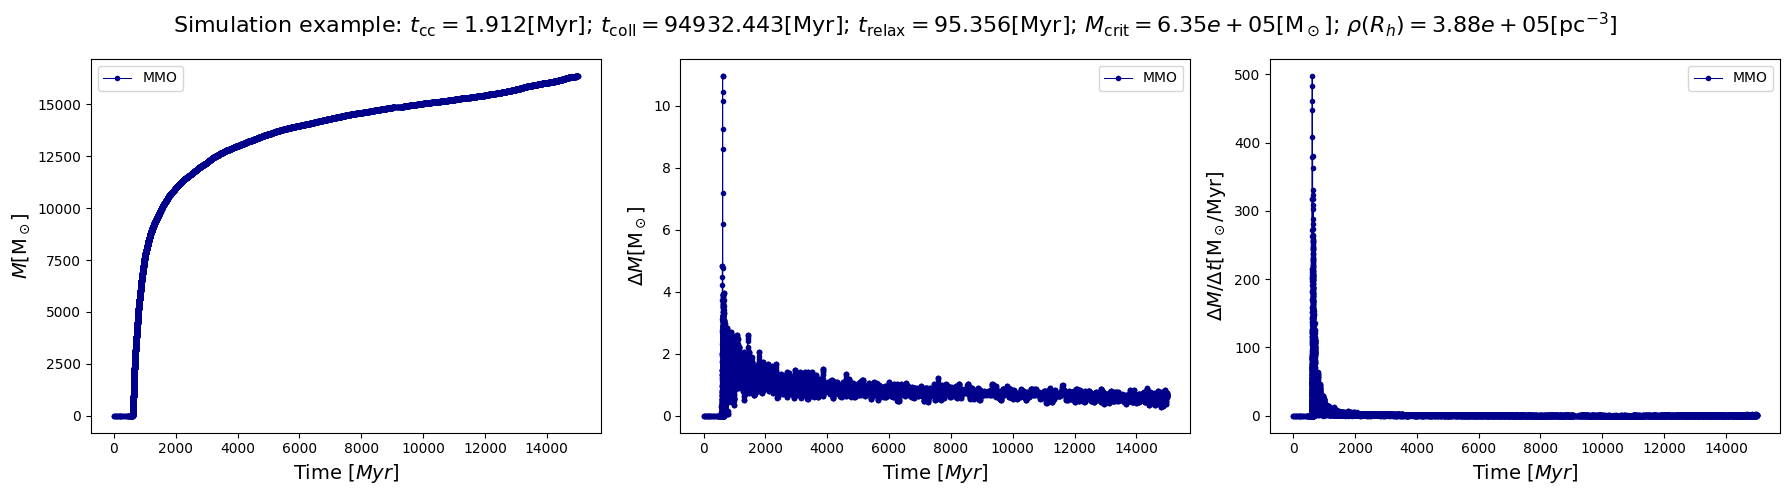

In [11]:
# We can plot a random example of a simulation and some relevan quantities of interest --------------------------#
example_df = imbh_df.drop_duplicates(subset="time[Myr]")

plot_simulation_example(df=example_df, target_types=["point_mass", "delta_mass", "mass_rate"],
                        t_relax   = t_relax.value,
                        t_coll    = t_coll.value,
                        t_cc      = t_cc.value,
                        rho_half  = rho_half.value,
                        M_crit    = M_crit.value,
                        show      = True)
#----------------------------------------------------------------------------------------------------------------#

In [12]:
# A full retrieve of the simulations can be made with the following class ---------------------------------------#
@dataclass
class ProcessingConfig:
    """Configuration class for processing parameters."""
    points_per_sim: Union[int, float] = 0.85
    n_virtual: int = 20
    train_split: float = 0.7
    val_split: float = 0.2
    test_split: float = 0.1
    min_points_threshold: int = 1000
    histogram_bins: int = 200
    downsample_min_count: int = 50
    downsample_max_count: int = 150

config   = ProcessingConfig()
exp_type = "point_mass"

data_processor         = DataProcessor(config)
downsampling_processor = DownsamplingProcessor(config)
#----------------------------------------------------------------------------------------------------------------#

In [13]:
# Process simulations -------------------------------------------------------------------------------------------#

# Retrieve original simulations
t_base, m_base, phy_base = data_processor.process_simulations(
                            simulations, 
                            exp_type, 
                            augmentation = False, 
                            apply_noise  = False, 
                            n_virtual    = None, 
                            verbose      = True)

# Perform a sampling augmentation and noise addition to the simulations
t_augm, m_augm, phy_augm = data_processor.process_simulations(
                            simulations, 
                            exp_type, 
                            augmentation = True, 
                            apply_noise  = True, 
                            n_virtual    = config.n_virtual,
                            verbose      = False)

# Downsampling the simulations retrieved using the a 2d histogram
t_down, m_down, phy_down = downsampling_processor.perform_downsampling(t_augm, m_augm, phy_augm)
#----------------------------------------------------------------------------------------------------------------#


Processing simulations: 100%|██████████| 455/455 [03:20<00:00,  2.26sim/s]

INFO: Simulation processing completed:
INFO:   - Total simulations processed   : 455
INFO:   - Simulations used              : 347
INFO:   - Simulations ignored           : 108
INFO:   - FAST formation channel sims   : 38
INFO:   - HYBRID formation channel sims : 173
INFO:   - SLOW formation channel sims   : 136
INFO:   - Average points per simulation : 8805.0 ± 7201.6



Processing simulations: 100%|██████████| 455/455 [04:13<00:00,  1.80sim/s]


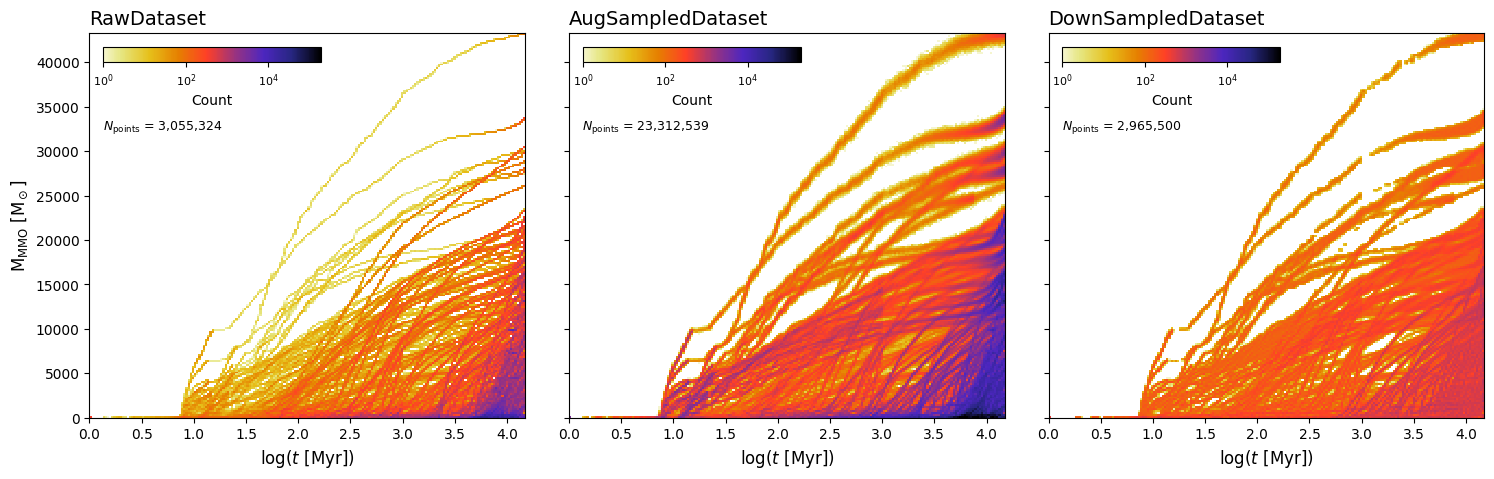

In [14]:
# Plot the files and observe the elements retrieved -------------------------------------------------------------#
cmap_trunc = truncate_colormap("CMRmap_r")
dataset_2Dhist_comparison(times_base = t_base, masses_base = m_base, 
                          times_aug  = t_augm, masses_aug  = m_augm,
                          times_filt = t_down, masses_filt = m_down, 
                          bins     = 200, 
                          cmap     = cmap_trunc,
                          show     = True)
#----------------------------------------------------------------------------------------------------------------#

## **$\bullet$ Dataset for ML estimation**

In [15]:
train_df = pd.read_csv("./datasets/massive_set/moccasurvey/0_fold/train.csv")
val_df   = pd.read_csv("./datasets/massive_set/moccasurvey/0_fold/val.csv")
test_df  = pd.read_csv("./datasets/massive_set/moccasurvey/test.csv")

In [ ]:
train_df = train_df[train_df["type_sim"]==2]
val_df   = val_df[val_df["type_sim"]==2]
test_df  = test_df[test_df["type_sim"]==2]

print(len(train_df))
print(len(val_df))
print(len(test_df))

In [16]:
# Plot features for point mass experiment

# Target
train_df["M_MMO/M_tot"]     = train_df["M_MMO"] / train_df["M_tot"]
train_df["log(M_MMO)"]      = np.log10(train_df["M_MMO"] +1) 

# Features
train_df["t/t_coll"]        = train_df["t"] / train_df["t_coll"]
train_df["t_coll/t_cc"]     = np.log10(train_df["t_coll"]/ train_df["t_cc"] + 1)
train_df["log(t)"]          = np.log10(train_df["t"] +1)
train_df["log(rho(R_h))"]   = np.log10(train_df["rho(R_h)"].to_numpy() + 1)
train_df["M_tot/M_crit"]    = train_df["M_tot"] / train_df["M_crit"] 
train_df["R_h/R_core"]      = train_df["R_h"] / train_df["R_core"] 
train_df["log(R_h/R_core)"] = np.log10(train_df["R_h/R_core"].to_numpy() + 1)
train_df["type_sim"]        = train_df["type_sim"].astype("category")

# Target
val_df["M_MMO/M_tot"]     = val_df["M_MMO"] / val_df["M_tot"]
val_df["log(M_MMO)"]      = np.log10(val_df["M_MMO"] +1) 

# Features
val_df["t/t_coll"]        = val_df["t"] / val_df["t_coll"]
val_df["t_coll/t_cc"]     = np.log10(val_df["t_coll"]/ val_df["t_cc"] + 1)
val_df["log(t)"]          = np.log10(val_df["t"] +1)
val_df["log(rho(R_h))"]   = np.log10(val_df["rho(R_h)"].to_numpy() + 1)
val_df["M_tot/M_crit"]    = val_df["M_tot"] / val_df["M_crit"] 
val_df["R_h/R_core"]      = val_df["R_h"] / val_df["R_core"] 
val_df["log(R_h/R_core)"] = np.log10(val_df["R_h/R_core"].to_numpy() + 1)
val_df["type_sim"]        = val_df["type_sim"].astype("category")

# Target
test_df["M_MMO/M_tot"]    = test_df["M_MMO"] / test_df["M_tot"]
test_df["log(M_MMO)"]     = np.log10(test_df["M_MMO"] +1) 

# Features
test_df["t/t_coll"]        = test_df["t"] / test_df["t_coll"]
test_df["t_coll/t_cc"]     = np.log10(test_df["t_coll"]/ test_df["t_cc"] + 1)
test_df["log(t)"]          = np.log10(test_df["t"] +1)
test_df["log(rho(R_h))"]   = np.log10(test_df["rho(R_h)"].to_numpy() + 1)
test_df["M_tot/M_crit"]    = test_df["M_tot"] / test_df["M_crit"] 
test_df["R_h/R_core"]      = test_df["R_h"] / test_df["R_core"] 
test_df["log(R_h/R_core)"] = np.log10(test_df["R_h/R_core"].to_numpy() + 1)
test_df["type_sim"]        = test_df["type_sim"].astype("category")

feature        = ["log(t)", "t_coll/t_cc" ,"M_tot/M_crit", "log(rho(R_h))", "log(R_h/R_core)", "M_MMO/M_tot"]
features_names = [  r"$\log(t)$",
                    r"$\log(t_{\rm{coll}}/t_{\rm cc})$", 
                    r"$M_{\rm tot}/M_{\rm crit}$", 
                    r"$\log(\rho(R_{h}))$",
                    r"$R_{h}/R_{\rm core}$", 
                    r"$M_{\rm MMO}/M_{\rm tot}$"]

In [ ]:
boxplot_features_with_points(features= train_df[feature], feature_names= features_names,
                 path_save    = "./figures/features/",
                 name_file    = "massive_set",
                 dataset_name = "moccasurvey",
                 point_color  = "wheat",
                 figsize      = (24,6))

In [ ]:
classic_correlogram(df= train_df[feature], method= "pearson", path_save="./figures/features/",
                    name_file= "massive_set",
                    dataset_name= "moccasurvey",
                    labels= features_names)

classic_correlogram(df= train_df[feature], method= "kendall", path_save="./figures/features/",
                    name_file= "massive_set",
                    dataset_name= "moccasurvey",
                    labels= features_names)

classic_correlogram(df= train_df[feature], method= "spearman", path_save="./figures/features/",
                    name_file= "massive_set",
                    dataset_name= "moccasurvey",
                    labels= features_names)

In [ ]:
from src.optim.optimizer          import SpaceSearch
from src.models.mltrees.regressor import MLTreeRegressor

In [ ]:
# Features
X_train = train_df[feature[:-1]+["type_sim"]].to_numpy()
X_val   = val_df[feature[:-1]+["type_sim"]].to_numpy()
X_test  = test_df[feature[:-1]+["type_sim"]].to_numpy()

# Target
y_train = train_df["M_MMO/M_tot"].to_numpy() 
y_val   = val_df["M_MMO/M_tot"].to_numpy() 
y_test  = test_df["M_MMO/M_tot"].to_numpy() 


In [ ]:
optimizer = SpaceSearch(model_type = "lightgbm", n_trials=100, verbose=True,
                        n_jobs         = 10,
                        seed           = 42,
                        load_if_exists = False)

In [ ]:
results = optimizer.run_study(X_train=X_train, y_train=y_train, X_val=X_val,y_val=y_val, 
                                study_name = "optuna_trial",
                                output_dir = "./outputs/massive_set/FULL/lightgbm/",
                                direction  = "minimize", 
                                metric     = "neg_mean_absolute_error",
                                save_study = True,
                                patience   = 20,
                                scaler     = val_df["M_tot"])

In [ ]:
from src.utils.directory import load_yaml_dict

In [ ]:
model_params = load_yaml_dict(path="./outputs/massive_set/FULL/lightgbm/optuna_trial/best_params.yaml")
#model_params["objective"] = "rmse"

In [ ]:
model = MLTreeRegressor(model_type   = "lightgbm",
                        n_jobs       = 10,
                        model_params = model_params,
                        feat_names   = feature[:-1]+["envirioment"],
                        verbose      = True)

train_model = model.fit(X_train=X_train, y_train=y_train)

In [ ]:
np.shape(X_test)

In [ ]:
metrics_val  = train_model.evaluate(X=X_val , y=y_val)
metrics_test = train_model.evaluate(X=X_test, y=y_test)

In [ ]:
print(metrics_val)
print(metrics_test)

In [ ]:
y_pred = model.predict(X=X_test, num_round=100)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Recovering natural units
y_rescaled_test = y_test * test_df["M_tot"]
y_rescaled_pred = np.clip(y_pred, 0, None) * test_df["M_tot"]

# Evaluation
mse  = mean_squared_error(y_rescaled_test, y_rescaled_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_rescaled_test, y_rescaled_pred)
r2   = r2_score(y_rescaled_test, y_rescaled_pred)

print(f"Test MSE  : {mse:.4f}")
print(f"Test RMSE : {rmse:.4f}")
print(f"Test MAE  : {mae:.4f}")
print(f"Test R2   : {r2:.4f}")

In [ ]:
from src.utils.vizualize import correlation_plot

In [ ]:
correlation_plot(predictions = y_rescaled_pred, 
                 true_values = y_rescaled_test, 
                 path_save   = "./figures/models/massive_set/", 
                 name_file   = "full_m_mmo_tweedie_test", 
                 model_name  = "LightGBM",
                 cmap        = "gist_heat_r",
                 scale       = None)


In [ ]:
# Get feature importances (e.g., by gain)
importances_dict = model.get_feature_importance()
# Convert to lists and sort by importance descending
features_names   = list(importances_dict.keys())
print(features_names)
importances      = list(importances_dict.values())

# Sort indices by importance descending
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(len(importances)), [importances[i] for i in indices], align='center', color="teal")
plt.xticks(range(len(importances)), [features_names[i] for i in indices], rotation=45, ha='right')
plt.ylabel('feature importance (gains)')
plt.tight_layout()
plt.show()